## This file consists of a small tweet classification pipeline. The goal is to classify tweets according to their language

In [107]:
import csv
import re

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import eli5

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import zero_one_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.metrics import SCORERS

In [2]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

In [3]:
from io import StringIO
import requests

def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [4]:
df_train_dev = load_dataset(url_train_dev)
df_test = load_dataset(url_test)

In [5]:
df_train_dev.head()

,tweet,label
0,يا من أناديها ويخنقني البكاء ويكاد صمت الدمع ...,ar
1,فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...,ar
2,ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...,ar
3,يا ابو سلو عرفتني,ar
4,ب50 ريال أكفل معتمر في رمضان ، ولك بإذن الله م...,ar


### Data Inspection

In the following, we will look at the data in more detail.

In [6]:
print(df_train_dev.label.unique().size)
print(df_train_dev.shape[0])

69
52675


We have 69 different labels. An interesting question that arises is how much of the data belongs to each label. In total, the training set has 52'675 entries.

In [7]:
counts = df_train_dev.groupby('label').count()
print( counts.sort_values('tweet', ascending=False))

print("Ratio of english tweets:", 100*counts.sort_values('tweet', ascending=False).iloc[0]['tweet'] / df_train_dev.shape[0], '%')

print('Number of classes that have less than 100 entries:', counts[counts['tweet'] < 100].shape[0])

         tweet
label         
en       18508
ja       10421
es        5930
und       4537
id        3006
...        ...
tn           1
dv           1
ta_LATN      1
si           1
ko_LATN      1

[69 rows x 1 columns]
Ratio of english tweets: 35.136212624584715 %
Number of classes that have less than 100 entries: 52


We can see that many languages contain very few entries. English tweets, for example, account for 35% of tweets in the train set, which is an extremely high number. Clearly, the classes are not all equally well represented. For example, 52 classes have less than 100 entries.

We can also briefly look at the tweets ('x' variable) to see if we can notice any interesting things.

In [8]:
print('Number of tweets that have less than 25 characters:',(df_train_dev['tweet'].iloc[:].str.len() < 25).sum())

Number of tweets that have less than 25 characters: 10288


For example, almost 1/5 of the tweets have less than 25 characters. It may be more difficult to classify these directly as we don't have a lot of information!

### Preprocessing 

Below, we define some functions we need for preprocessing the data.

Often something like sentence segmentation is used for such NLP tasks. Since we are working with tweets, this may not be a good idea as we're often working with tweets that are fragments of sentences.

As our models treat upper case and lower case differently, we will lowercase all the words as a first pre-processing step. Further, we also remove URLs as they do not add any information. For a similar reason as lowercasing, we can remove all punctuation that's unnecessary!

Often, stop words are also removed. We will not do this as there are many different languages and the stop word databases are probably not as good for all of them.

We remove emojis completely. This is not the ideal solution. We could alternatively transform them to their textual meaning.

In [9]:
def convert_lowercase(txt):
    txt = txt.lower()
    return txt

def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)  # I received an TypeError, so i changed 'text' to str(text) 

import string
exclude = string.punctuation
def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

import emoji
def demojize_emojis(text):
    return emoji.demojize(text)

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
    
# function to remove special characters
def remove_special(text):
    x=''
    for i in text:
        if i.isalnum():
            x=x+i
        else:
            x=x+' '
    return x

# not sure if this is needed;
def none_to_empty_string(text):
    if not text:
        text = ""
    return text

In [10]:
X_train_dev = df_train_dev['tweet'].apply(remove_emoji)
X_train_dev = X_train_dev.apply(convert_lowercase)
X_train_dev = X_train_dev.apply(remove_url)
X_train_dev = X_train_dev.apply(remove_punc)
X_train_dev = X_train_dev.apply(none_to_empty_string)


In [11]:
X_train_dev[10000]

'fuck cmon argentina tie the game please '

### Label Encoding

Further, I need to encode the label. We will use a custom encoder for that. Since we want the same encoded values in our test data, we fit the label encoder on our train data and then use the transform. This ensures that we have the same labels for the same lanuages. The same procedure is done for the vectorizer, as we vectorize first on the train set and then on the validation set

In [12]:
def custom_encoder(v, d):
    if d == None:
        d = {}
    cur_value = 0
    for i in range(len(v)):
        if v[i] in d:
            v[i] = d[v[i]]
        else:
            d[v[i]] = cur_value
            v[i] = d[v[i]]
            cur_value += 1
    return v, d

In [13]:
y_train_dev, current_dictionary = custom_encoder(df_train_dev['label'], None)

In [14]:
y_train_dev = y_train_dev.astype('int')

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train_dev, y_train_dev, test_size=0.1, random_state=99)

### Vectorization of data

We Note, we didn't do the tokenization before, as the vectorizer does this for us.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=None)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)

### Transforming the test data
Before we do any training, let's also preprocess the test data. The same preprocessing steps as before are applied

In [17]:
X_test = df_test['tweet'].apply(remove_emoji)
X_test = X_test.apply(convert_lowercase)
X_test = X_test.apply(remove_url)
X_test = X_test.apply(remove_punc)
X_test = X_test.apply(none_to_empty_string)

In [18]:
X_test = vectorizer.transform(X_test)

In [19]:
y_test = custom_encoder(df_test['label'], current_dictionary)[0]

### Training the Logistic Regression Model

Now, let us train the logistic Regression

In [20]:
clf = LogisticRegression(random_state=99).fit(X_train, y_train)

C:\Users\Damja\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
y_pred_prob = clf.predict_proba(X_val)
y_pred = clf.predict(X_val)

Let's look at the loss we have generated. We will use the zero one loss.

In [22]:
print((1 - zero_one_loss(y_val, y_pred))*100, '%')

80.84662110858011 %


In the validation set, we have correctly classified 80.8% of the tweets! This seems like a good first value.
Let's just quickly look at the performance in the test set. 

In [23]:
y_test_pred = clf.predict(X_test)

In [24]:
correct_count = 0

for i in range(len(y_test)):
    if y_test.iloc[i] == y_test_pred[i]:
        correct_count += 1

print(correct_count/len(y_test_pred)*100, '%')

79.52406054672791 %


On the test set, the performance is slightly worde, but still very good. We classify 79.5% of the tweets correctly. 

### Experimenting with different settings
- different penalties
- different solvers
- optionally: different parameters of the vectorizer

In [25]:
params = {
    'penalty' : ["l1", "l2", "elasticnet"],
    'solver' : ["newton-cg", "lbfgs", "liblinear"]
}

logreg = LogisticRegression()
clf = GridSearchCV(logreg, params)
clf.fit(X_train, y_train)


C:\Users\Damja\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Damja\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Damja\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Damja\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Damja\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Damja\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']})

In [26]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_penalty',
 'param_solver',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [27]:
y_pred_val = clf.predict(X_val)
print((1 - zero_one_loss(y_val, y_pred_val))*100, '%')

81.70083523158695 %


In [28]:
y_test_pred = clf.predict(X_test)

In [29]:
correct_count = 0

for i in range(len(y_test)):
    if y_test.iloc[i] == y_test_pred[i]:
        correct_count += 1

print(correct_count/len(y_test_pred)*100, '%')

80.56329542887266 %


In [41]:
clf.best_estimator_

LogisticRegression(penalty='l1', solver='liblinear')

### Confusion Matrix

In [92]:
conf_mat = pd.DataFrame(confusion_matrix(list(y_test.values), y_test_pred))

In [93]:
print(conf_mat)


     0   1   2   3   4   5   6   7   8   9   ...  43  44  45   46  47  48  49  \
0   407   0   0   0   0   0   0   0   0   0  ...   0   0   0    6   0   0   0   
1     0   0   0   0   0   0   0   0   0   0  ...   0   0   0    0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0  ...   0   0   0    0   0   0   0   
3     0   0   0   0   0   0   0   0   0   0  ...   0   0   0    1   0   0   0   
4     0   0   0   0   0   0   0   0   0   0  ...   0   0   0    0   0   0   0   
5     0   0   0   0   0   0   0   0   0   0  ...   0   0   0    1   0   0   0   
6     0   0   0   0   0   0   0   0   0   0  ...   0   0   0    1   0   0   0   
7     0   0   0   0   0   0   0   0   0   0  ...   0   0   0    0   0   0   0   
8     0   0   0   0   0   0   0   0   0   0  ...   0   0   0    0   0   0   0   
9     0   0   0   0   0   0   0   0   0   0  ...   0   0   0    0   0   0   0   
10    0   0   0   0   0   0   0   0   0   0  ...   0   0   0    1   0   0   0   
11    0   0   0   0   0   0 

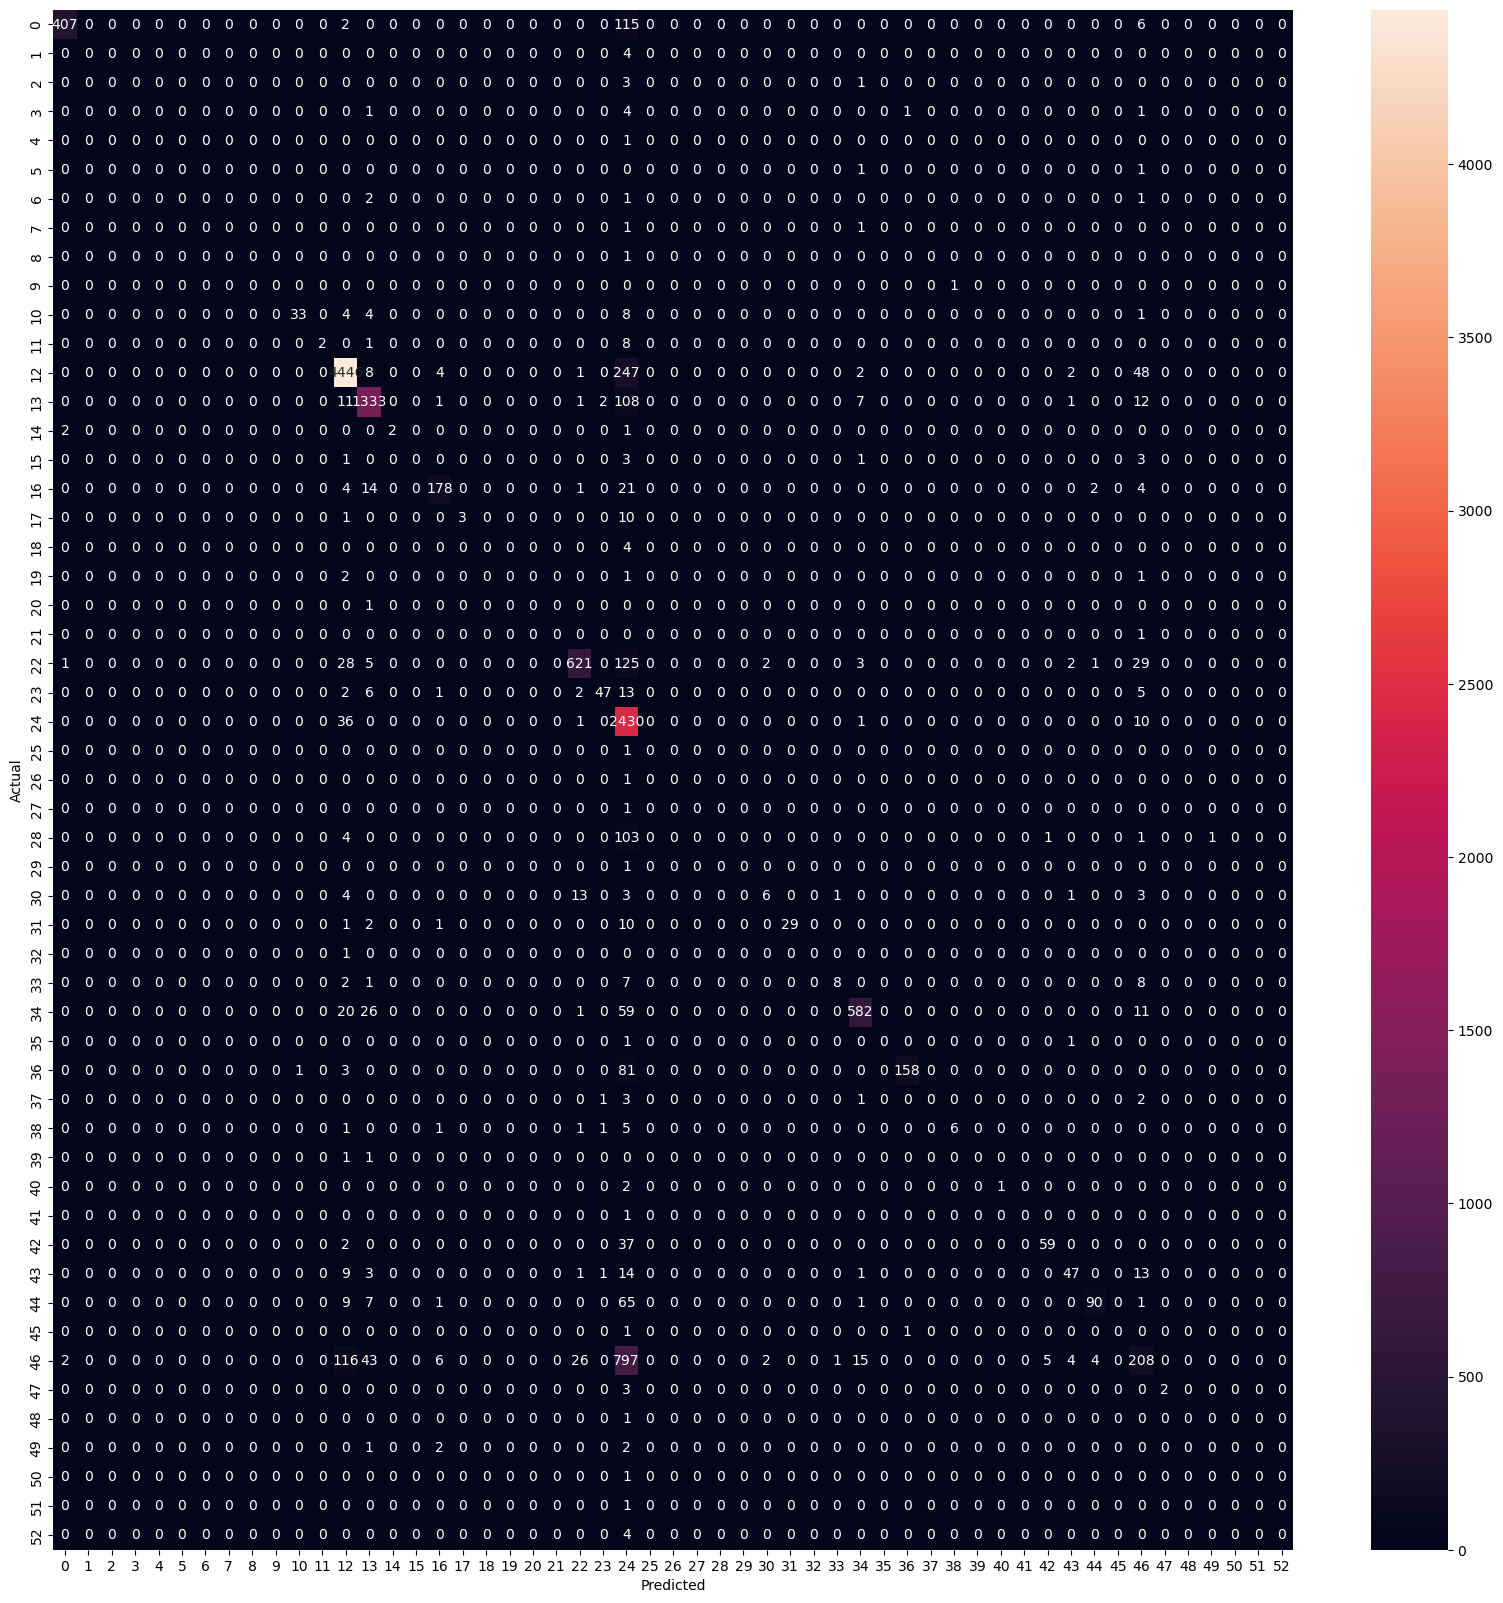

In [99]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [115]:
X_test

<13279x98682 sparse matrix of type '<class 'numpy.int64'>'
	with 72846 stored elements in Compressed Sparse Row format>

In [123]:
eli5.show_weights(clf.best_estimator_)

In [127]:
eli5.show_weights(clf.best_estimator_, top=10)

In [129]:
current_dictionary.keys()

dict_keys(['ar', 'ar_LATN', 'az', 'bg', 'bn', 'bs', 'ca', 'cs', 'cy', 'da', 'de', 'dv', 'el', 'en', 'es', 'et', 'fa', 'fi', 'fr', 'gl', 'ha', 'he', 'hi', 'hi-Latn', 'hr', 'ht', 'hu', 'hy', 'id', 'is', 'it', 'ja', 'ja_LATN', 'jv', 'km', 'ko', 'ko_LATN', 'ms', 'ne', 'nl', 'no', 'pl', 'ps', 'ps_LATN', 'pt', 'ro', 'ru', 'si', 'sl', 'sq', 'sr', 'su', 'sv', 'sw', 'ta', 'ta_LATN', 'th', 'tl', 'tn', 'tr', 'uk', 'und', 'ur', 'ur_LATN', 'vi', 'wo', 'xh', 'zh-CN', 'zh-TW', 'mr', 'mn', 'eu', 'lv', 'zu', 'la', 'yo', 'mk', 'sk'])